In [1]:
using Plots
using ParticleFilters
using Distributions
using StaticArrays
using LinearAlgebra
using Random
using StatsBase
#using Reel
using SparseArrays
using GridInterpolations
using DataStructures
using DataFrames
using CSV
using Distributed

In [44]:

include("atan2.jl")
include("obs_rel.jl")
include("polargrid_rel_qual2.jl")
rng = MersenneTwister(2);
#

In [3]:
# random walk

POS_0 = [6.0, 60.0]
CRS_0 = 90 # target's course
SPD_0 = 1 # 1 or 2
TGT_SPD = 1

#input is course in degrees and rng
#returns next course in degrees
function next_crs(crs,rng)
    if rand(rng) < .9
        return crs
    end
    crs = (crs + rand(rng,[-1,1])*30) % 360
    if crs < 0 crs += 360 end
    return crs
end

# state as tuple (x, y, crs, spd) of target (spd of o/s)
function f(state, control, rng)
    r, θ, crs, spd = state
    θ += control[1]
    spd = control[2]
    if θ < 0 θ += 360 end
    θ = θ % 360
    crs -= control[1]
    if crs < 0 crs += 360 end
    crs = crs % 360
    x = r*cos(π/180*θ)
    y = r*sin(π/180*θ)
    pos = [x + TGT_SPD*cos(π/180*crs) - spd, y + 
        TGT_SPD*sin(π/180*crs)]
    crs = next_crs(crs,rng)
    r = sqrt(pos[1]^2 + pos[2]^2)
    θ = atan2(pos[1],pos[2])*180/π
    if θ < 0 θ += 360 end
    return (r, θ, crs, spd)::NTuple{4, Real}
end
#

f (generic function with 1 method)

In [34]:
function r(s)
    range = s[1]
    if range > 150 return -.2 end  # reward to not lose track of contact
    if range <= 10 return -100 end  # collision avoidance
    return .1  # being in "sweet spot" maximizes reward
end
#

r (generic function with 1 method)

In [5]:
#angles = [0, 30, 60, 90, 120, 150, 210, 240, 270, 300, 330]

statespace = thestates
actionspace = ((30,1), (0,1), (-30,1), (30, 2), (0,2), (-30,2))

action_index(a) = trunc(Int, 2*(a[1]/30+1) + a[2])
actions_ = ((-30,1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))



((-30, 1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))

In [6]:
# returns vector rather than Tuple, for particle filter
function f2(x, u, rng)
    temp = [i for i in f(x, u, rng)]
    return temp
end

f2 (generic function with 1 method)

In [31]:
totals = [0.0]
#θ = zeros(length(grid),6);
e = sparse(zeros(length(grid),6))
#θ = [r(Tuple(ind2x(grid, j))) for j in 1:length(grid), i in 1:6];

In [8]:

N = 400
model = ParticleFilterModel{Vector{Float64}}(f2, g)
pfilter = SIRParticleFilter(model, N);
α = 0.3
γ = 0.98
ϵ = 0.3
x = [20, 60, 90, 1, 1];
λ = 0.98
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
counter = 0
epochsize = 100

0

In [ ]:
## Q-learning loop
#plots = []
#betas = Deque{Array}()
#β = zeros(length(grid),6);

epochs = 15000


total = 0
rando = 0
k = 15
last = 0
x = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, 1, 1];     
b = ParticleCollection([x[1:4] for i in 1:N]);     
ξ = sparse(weighted_grid_2(b)/N)
uu = softmax_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], k, rng)
u = uu[1]
rando += uu[2]

for i in 1:(epochsize*epochs)
    counter += 1
    
    e[:,u] += ξ
    last = transpose(θ[:,u])*ξ
    
    # choose next action
    uu = softmax_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], k, rng)
    u = uu[3]
    rando += uu[2]
    a_star = uu[3]
    
    #observe new state and reward
    xp = f2(x, actions_[u], rng)
    y = h(xp, rng)
    b = update(pfilter, b, actions_[u], y)
    rew = r(Tuple(xp))
       
    ξ = sparse(weighted_grid_2(b)/N)
     
    total += rew
        
    #cur = (rew + γ * max2([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], rng))
    
    #argmax state-action pair, not realized state-action pair?
    cur = transpose(θ[:,a_star])*ξ
    
    δ = rew + γ * cur - last
    
    θ += α * δ * e
    #if uu[2] == 0
    e *= γ * λ
    #else
    #    e = sparse(zeros(length(grid),6))
    #end
    
    
    
    if (counter % epochsize == 0) || (xp[1] <= 10)
        push!(totals, total*500/epochsize)
        running_avg = round(mean(totals), sigdigits=4)
        println("--------- CURRENT: ", round(total*500/epochsize, sigdigits=4), " AVG: ", running_avg, 
            " Epoch: ", trunc(Int, counter/epochsize), " -----------")
        total = 0
        rando = 0
        xp = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, rand(rng, [1,2]), 1];
        b = ParticleCollection([xp[1:4] for i in 1:N]);
        ξ = sparse(weighted_grid_2(b)/N)
        if (running_avg > 25) && (counter > (epochsize*100))
            epochsize += 50
            totals = [0.0]
            counter = 0
            println("------ NEW EPOCH SIZE: ", epochsize, " -------------")
        end
        if running_avg > 0 
            k = max(running_avg, 1)
        else
            k = 1
        end
    end
    if counter % (epochsize*5) == 0
        thetaframe = DataFrame(θ)
        CSV.write("current473.csv", thetaframe)
    end
    
    x = xp
    
    
    #plotting
    #r_ = [row[1] for row in particles(b)]
    #theta = [row[2] for row in particles(b)]*π/180
    #x_theta = x[2]*π/180
    #x_r = x[1 ]
    
    #print(".")
    #plt = plot(proj=:polar, lims=(0,200), size=(1000,1000))
    #scatter!(theta, r_, markersize=1, label="particles")
    #scatter!([x_theta], [x_r], markersize=3, label="target")
          
    #push!(plots, plt)
    
end


--------- CURRENT: 14.87 AVG: 28.72 Epoch: 3 -----------
--------- CURRENT: 50.0 AVG: 32.97 Epoch: 4 -----------
--------- CURRENT: 50.0 AVG: 35.81 Epoch: 5 -----------
--------- CURRENT: 50.0 AVG: 37.84 Epoch: 6 -----------
--------- CURRENT: 50.0 AVG: 39.36 Epoch: 7 -----------
--------- CURRENT: 50.0 AVG: 40.54 Epoch: 8 -----------
--------- CURRENT: 50.0 AVG: 41.49 Epoch: 9 -----------
--------- CURRENT: 50.0 AVG: 42.26 Epoch: 10 -----------
--------- CURRENT: 50.0 AVG: 42.91 Epoch: 11 -----------
--------- CURRENT: 50.0 AVG: 43.45 Epoch: 12 -----------
--------- CURRENT: 50.0 AVG: 43.92 Epoch: 13 -----------
--------- CURRENT: -65.4 AVG: 36.63 Epoch: 13 -----------
--------- CURRENT: 48.67 AVG: 37.38 Epoch: 14 -----------
--------- CURRENT: 50.0 AVG: 38.13 Epoch: 15 -----------
--------- CURRENT: 50.0 AVG: 38.79 Epoch: 16 -----------
--------- CURRENT: 50.0 AVG: 39.38 Epoch: 17 -----------
--------- CURRENT: 50.0 AVG: 39.91 Epoch: 18 -----------
--------- CURRENT: 50.0 AVG: 40.39 

--------- CURRENT: 50.0 AVG: 46.37 Epoch: 49 -----------
--------- CURRENT: 50.0 AVG: 46.44 Epoch: 50 -----------
--------- CURRENT: 50.0 AVG: 46.5 Epoch: 51 -----------
--------- CURRENT: 50.0 AVG: 46.57 Epoch: 52 -----------
--------- CURRENT: 50.0 AVG: 46.63 Epoch: 53 -----------
--------- CURRENT: 50.0 AVG: 46.69 Epoch: 54 -----------
--------- CURRENT: 50.0 AVG: 46.75 Epoch: 55 -----------
--------- CURRENT: 50.0 AVG: 46.81 Epoch: 56 -----------
--------- CURRENT: 50.0 AVG: 46.86 Epoch: 57 -----------
--------- CURRENT: 50.0 AVG: 46.91 Epoch: 58 -----------
--------- CURRENT: 50.0 AVG: 46.96 Epoch: 59 -----------
--------- CURRENT: 50.0 AVG: 47.01 Epoch: 60 -----------
--------- CURRENT: 50.0 AVG: 47.06 Epoch: 61 -----------
--------- CURRENT: 50.0 AVG: 47.11 Epoch: 62 -----------
--------- CURRENT: 50.0 AVG: 47.15 Epoch: 63 -----------
--------- CURRENT: 1.438 AVG: 46.46 Epoch: 64 -----------
--------- CURRENT: 50.0 AVG: 46.51 Epoch: 65 -----------
--------- CURRENT: 50.0 AVG: 46

--------- CURRENT: 50.0 AVG: 46.19 Epoch: 88 -----------
--------- CURRENT: 50.0 AVG: 46.23 Epoch: 89 -----------
--------- CURRENT: 50.0 AVG: 46.27 Epoch: 90 -----------
--------- CURRENT: 50.0 AVG: 46.31 Epoch: 91 -----------
--------- CURRENT: 50.0 AVG: 46.35 Epoch: 92 -----------
--------- CURRENT: 50.0 AVG: 46.39 Epoch: 93 -----------
--------- CURRENT: 50.0 AVG: 46.42 Epoch: 94 -----------
--------- CURRENT: 50.0 AVG: 46.46 Epoch: 95 -----------
--------- CURRENT: 50.0 AVG: 46.49 Epoch: 96 -----------
--------- CURRENT: 50.0 AVG: 46.53 Epoch: 97 -----------
--------- CURRENT: 50.0 AVG: 46.56 Epoch: 98 -----------
--------- CURRENT: 50.0 AVG: 46.6 Epoch: 99 -----------
--------- CURRENT: 50.0 AVG: 46.63 Epoch: 100 -----------
--------- CURRENT: 50.0 AVG: 46.66 Epoch: 101 -----------
------ NEW EPOCH SIZE: 900 -------------
--------- CURRENT: 50.0 AVG: 25.0 Epoch: 1 -----------


43.439849624060365

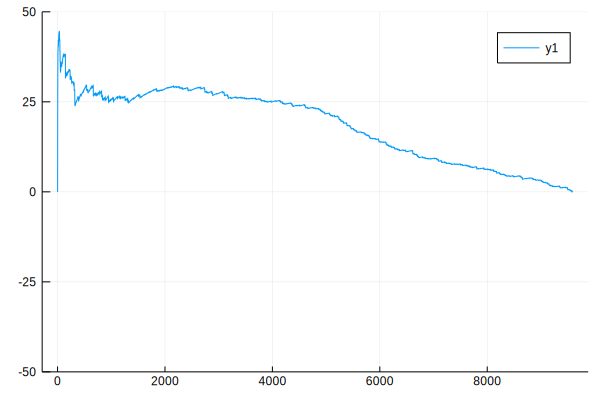

In [24]:
xx = []
yy = []
yyy = []
for (i, t) in enumerate(totals)
    push!(xx, i)
    push!(yy, t)
    push!(yyy, mean(yy))
end

plot(xx, yyy, ylims = (-50,50))

In [30]:
#θ = convert(Matrix, CSV.read("0.44_theta_12.3_1_excellent_200.csv"))


In [17]:
#θ = convert(Matrix, thetaframe)

In [16]:
thetaframe = DataFrame(θ)
CSV.write("0.461_theta_12.2_1_good", thetaframe)

"0.461_theta_12.2_1_good"

In [51]:
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
ξ = weighted_grid_2(b)/N
var(ξ)


3.5612535612535624e-5